# Project - Compressed Sensing :

## Optimization via Low Rank Approximation for Community Detection in Networks

- Detection network community structure ie infering label vector $c \in \{1,....,K\}^n$ for n nodes from adjency matrix $A \in \mathcal{M}_{n\times n}$
- Hypothese : K is given, undirected network (A symmetric)
- Trend : fit probabilistic model for the adjency  matrix A / or optimizing global criteria derived from other considerations over label assignments c (ex : spectral approximation)

### SBM : Stochastic Block Model

In [1]:
import numpy as np

# K = 2, p, q given
class SBM : 
    def __init__(self,n, p, q):
        self.n = n
        self.probas = (q,p)
        
        self.labels = [np.argmax(np.random.multinomial(1, [1/2, 1/2])) for i in range(n)]
        
        self.adjency_matrix = np.identity(n)
        self.edges = []
        self.get_adjency_edges()
        
#     def __init__(self,n, p, q K=2):
#         self.n = n
#         # Generate labels from multinomial distribution pi = [pi_0, .., pi_K] 
#         self.labels = np.random.multinomial(n, [1/K for k in range(K)])
#         # Adjency matrix initialisation
#         self.adjency_matrix = np.zeros((n,n))
    
    def get_adjency_edges(self):
        for i in range(self.n):
            for j in range(i):
                # FAUX
                edge = np.random.binomial(1,self.probas[int(self.labels[i] == self.labels[j])])
                if edge == 1 :
                    self.edges.append((i,j))
                    self.adjency_matrix[i,j] = edge
                    self.adjency_matrix[j,i] = edge

### DCSBM : Degree-Corrected SBM

In [2]:
import numpy as np

# K = 2, p, q given and a custom theta
class DCSBM : 
    def __init__(self,n, p, q, theta):
        self.n = n
        self.probas = (q,p)
        self.theta = theta
        self.labels = [np.argmax(np.random.multinomial(1, [1/2, 1/2])) for i in range(n)]
        self.adjency_matrix = np.zeros((n,n))
        self.edges = []
        self.get_adjency_edges()
        
    def get_adjency_edges(self):
        for i in range(self.n):
            for j in range(i):
                if self.labels[i] == self.labels[j] : 
                    edge = np.random.binomial(1,self.theta[i]*self.theta[j]*self.probas[int(self.labels[i] == self.labels[j])])
                    if edge == 1 :
                        self.edges.append((i,j))
                    self.adjency_matrix[i,j] =edge

In [3]:
graph = SBM(30,0.007,0.1)
graph = DCSBM(30,0.007,0.1, [np.random.randint(1,5)/2 for i in range(30)])

In [4]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_network(graph):
# Graph Representation Parameters 

    graph_layout='random'
    node_size=100
    node_color='black'
    node_alpha=0.8
    node_text_size=6
    edge_color='black'
    edge_alpha=0.1
    edge_tickness=1

    text_font='sans-serif'


    # create networkx graph
    G=nx.Graph()

    for node in range(graph.n):
        G.add_node(node)
    # add edges
    for edge in graph.edges:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Network as you observe it')

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    # nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
    #                         font_family=text_font)

    edge_labels = dict(zip(graph.edges, graph.labels))
    #nx.draw_networkx(G, graph_pos)# edge_labels=,  label_pos=edge_text_pos)

    # show graph
    plt.subplot(122)
    plt.title('Network with ground truth communities')
    nx.draw_networkx_nodes(G,graph_pos,
                           nodelist=[node for node,label in enumerate(graph.labels) if label==0],
                           node_color='r',
                           node_size=node_size,
                           alpha=node_alpha)

    nx.draw_networkx_nodes(G,graph_pos,
                           nodelist=[node for node,label in enumerate(graph.labels) if label==1],
                           node_color='b',
                           node_size=node_size,
                           alpha=node_alpha)

    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    #nx.draw_networkx(G, graph_pos)# edge_labels=,  label_pos=edge_text_pos)


    plt.show()


# you may name your edge labels
#draw_graph(graph, labels)

# if edge labels is not specified, numeric labels (0, 1, 2...) will be used

- Fitting models such as SMB involves maximizing likelihood function over all possible label assigmnets which is NP-Hard in practise.
- One can use MCMC, Variational Methods as well

**Profile Likelihood :**

When the likelihood function depends on many parameters, depending on the application, we might be interested in only a subset of these parameters. It is often possible to reduce the number of the uninteresting (nuisance) parameters by writing them as functions of the parameters of interest. For example, the functions might be the value of the nuisance parameter which maximizes the likelihood given the value of the other (interesting) parameters.

This procedure is called concentration of the parameters and results in the concentrated likelihood function, also occasionally known as the maximized likelihood function, but most often called the **profile likelihood function**. It is then possible (and simpler) to find the values of the parameters which maximizes the profile likelihood function (similar to the maximum likelihood).

In this paper, we'll be interested in maximimizing several criteria : 
- **profile likelihood of the degree-corrected SBM (DCSBM)**
- **profile likelihood of the SBM.**
- **the Newman-Girvan modularity**
- **the community extraction criterion**

**Modularity** : 

compare the observed networl to a null model that has no community structure
- $e$ be an n-dimensional label vector.
- $n_k(e) = \sum_{i=1}^n I(e_i=k)$ nb of nodes in the community k
- $O_{kl}(e) = \sum_{i=1}^n\sum_{j=1}^n A_{ij}I(e_i=k, e_j=l)$ nb of edges between communities k and l ($k \ne l$)
- $O_k = \sum_{l=1}^K O_{kl}$ the sum of node degrees in community k 
- $d_i = \sum_{j=1}^n A_{ij}$ degree of node i 
- $m = \sum_{i=1}^n d_i$ (twice) the total of number of edges in the graph

-> Newman-Girvan Modularity : derived by comparing the observed nb of edges within communities to the number that would be expected under the Chung-Lu model for the entire graph : 

$$ Q_{NG}(e) = \frac{1}{2m} \sum_k (O_{kk} - \frac{O_k^2}{m})$$

**Profile likelihoods of SBM and DCSBM** : 

$$ Q_{BM}(e) =  \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{n_kn_l} $$
$$ Q_{DC}(e) =  \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{O_kO_l} $$

**Extraction Criteria** :

recognize that some nodes may not belong to anu community and the strength of a community should depend on ties between its members and ties to the outside world (but not on ties between non-members). Criterion is non symmetric wrt commumnities.

$$Q_{EX}(V) = |V||V^c|\left(\frac{O(V)}{|V|^2} - \frac{B(V)}{|V||V^c|}\right)$$

where : 
- V : the set of nodes in the community to be extracted
- $V^c$ complement of V
- $O(V) = \sum_{i,j \in V} A_{ij}$
- $B(V) = \sum_{i \in V, j \in V^c} A_{ij}$

The optimization of this criterion is done via greedy label switching (ex : tabu seach algorithm)

**Contribution of paper** : a new general method for optimizing a general function $f(A,e)$ (+ conditions) over labels e.
- Start by projecting the entire feasible set of lebesl onto a low-dimension subspace spanned by vectors approximating the leading eigenvectors of EA.
- It reduces rge number of possible solutions (extreme points) from exponential to polynomial (here $O(2^n)$ to $O(n)$ for 2 communities) which makes the oprtimization easier.

They show how this method can be applied to the 4 criteria aboves ( profile LKHD of DCSBM, SBM, Newman-Girvan and Extraction criteria)

### 3. Application to Community Detection in Networks.

Recall of the notation
- $e$ be an n-dimensional label vector.
- $n_k(e) = \sum_{i=1}^n I(e_i=k)$ nb of nodes in the community k
- $O_{kl}(e) = \sum_{i=1}^n\sum_{j=1}^n A_{ij}I(e_i=k, e_j=l)$ nb of edges between communities k and l ($k \ne l$)
- $O_k = \sum_{l=1}^K O_{kl}$ the sum of node degrees in community k 
- $d_i = \sum_{j=1}^n A_{ij}$ degree of node i 
- $m = \sum_{i=1}^n d_i$ (twice) the total of number of edges in the graph

-> Newman-Girvan Modularity : derived by comparing the observed nb of edges within communities to the number that would be expected under the Chung-Lu model for the entire graph : 

$$ Q_{NG}(e) = \frac{1}{2m} \sum_k (O_{kk} - \frac{O_k^2}{m})$$

**Profile likelihoods of SBM and DCSBM** : 

$$ Q_{BM}(e) =  \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{n_kn_l} $$
$$ Q_{DC}(e) =  \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{O_kO_l} $$

Here we focus on the case K=2

One can then re-write $O_{kl}$ with k,l=1,2 ie $O_{11}$, $O_{12}$($=O_{12}$), $O_{22}$ as : 
- $O_{11}(e) = \sum_{i=1}^n\sum_{j=1}^n A_{ij}I(e_i=1, e_j=1) = \frac{1}{4}(1 + e)^T A (1+e)$

This can be simply verified : 

$$O_{11}(e) = \frac{1}{4}(1 + e)^T A (1+e) =  \frac{1}{4}  \sum_{i=1}^n\sum_{j=1}^n A_{ij}(1 + e_i)(1 + e_j)$$

and $(1 + e_i)(1 + e_j) = \left\{ \begin{array}{ll}
        0 &  \mbox{ if } e_i \mbox{ or } e_j = -1  \\
        4  & \mbox{ if } e_i=e_j=1
    \end{array}\right. = 4 I(e_i=1, e_j=1)$
    
Similarly : 
- $O_{22}(e) = \frac{1}{4}(1 - e)^T A (1-e)$
- $O_{12}(e) = \frac{1}{4}(1 + e)^T A (1-e)$

### Maximizing the likelihood of DCSBM 

$$ \begin{array}{c,c,l}
Q_{DC}(e) & = & \sum_{k=1}^K\sum_{l=1}^K O_{kl}\log \frac{O_{kl}}{O_kO_l} \mbox{ with K=2} \\
& = & O_{11}\log \frac{O_{11}}{O_1O_1} + 2 O_{12}\log \frac{O_{12}}{O_1O_2} +  O_{22}\log \frac{O_{22}}{O_2O_2}\\
& = & O_{11}\log O_{11} + O_{22}\log O_{22} + 2O_{12}\log O_{12} - 2(O_{11} + O_{12}) \log{O_1} - 2(O_{22} + O_{12}) \log{O_2}\\
& = & O_{11}\log O_{11} + O_{22}\log O_{22} + 2O_{12}\log O_{12} - 2O_{1}\log O_{1} - 2O_{2}\log O_{2}
\end{array}$$


In [5]:
# Remarque : theta = node degree parameter is iid sample from distribution 
# E(theta_i)=1 and 1/xi \leq theta_i \leq xi for some xi \geq 1

xi = 2
n = 30
theta = np.minimum(np.maximum(np.random.poisson(4, size=n)/4,1/xi),xi)
np.mean(theta)

0.975

In [6]:

# K = 2, p, q given
class DCSBM : 
    def __init__(self,n, lambda_n, r, w):
        self.n = n
        self.probas = lambda_n*np.array([[1,r],[r,w]])
        self.theta =  np.minimum(np.maximum(np.random.poisson(4, size=n)/4,1/xi),xi)
        self.labels = [np.argmax(np.random.multinomial(1, [1/2, 1/2])) for i in range(n)]
        self.adjency_matrix = np.zeros((n,n))
        self.edges = []
        self.get_adjency_edges()
        
    def get_adjency_edges(self):
        for i in range(self.n):
            for j in range(i):
                #draw A_ij = Bernouilly(theta_i * thetaj * Pc_i, c_j)
                ci, cj = self.labels[i], self.labels[j]
                edge = np.random.binomial(1,self.theta[i]*self.theta[j]*self.probas[ci, cj])
                if edge == 1 :
                    self.edges.append((i,j))
                self.adjency_matrix[i,j] =edge

In [7]:
graph = DCSBM(n = 30, lambda_n = 1/20, r = 0.3, w = 2)

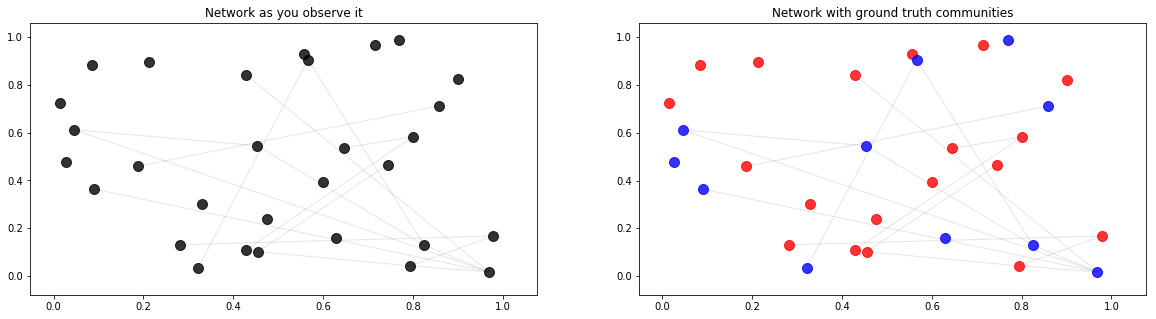

In [8]:
plot_network(graph)

**Theorem 3.1** :

Let A be the adjency matrux genereated from the DCSBM with $\lambda_n$ growing at least as $\log^2n$ as $n \to \inf$.
Let $U_A$ be an approximation of $U_{\mathbb{E}(A)}$ abd e* the label vector with $f_A = Q_{DC}$.
Then for any $\delta \in (0,1)$, there exists a constant $M=M(r, w, \pi, \xi, \delta) > 0$ such that with proba at least $1- \delta$, we have : 

$$ \frac{1}{n}||c - e^*||^2 \leq M \log n \left( \lambda_n^{-1/2} + || U_A -  U_{\mathbb{E}(A)}||\right)$$

In particular, if $U_A$ is a matrix whose row vectors are leading eigenvectors of A, then the fraction of mis-clustered nodes is bounded by $M \frac{ \log n}{\sqrt{\lambda_n}}$

In [14]:
# Packages 

import tqdm
import scipy
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

from scipy.sparse.linalg import eigsh
import time
import os
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

from scipy.cluster.vq import whiten, kmeans
from numpy import linalg as LA
from networkx.algorithms.cuts import conductance
from scipy.sparse.linalg import eigsh


# Parametrization 

n = 300
K = 2
gamma = 0.5

lambda_n = 15
eps = 0.5
tau = eps * lambda_n /n
r = 0.2
w = 1


#Theta : 
#theta = [np.random.binomial(1,gamma) for draw in range(n)]
#theta = [0.2 if draw==1 else 1 for draw in theta ]
#print(theta[:10])


In [15]:
class DCSBM :
    
    ''' Degree-Corrected Stochastic Block Model'''
    
    def __init__(self,n, lambda_n, r, w):
        self.n = n
        self.probas =np.array([[1,r],[r,w]])
        
        self.theta = [np.random.binomial(1,gamma) for draw in range(self.n)]
        self.theta = [0.2 if draw==1 else 1 for draw in self.theta ]  

        P = lambda_n* self.probas / ((self.n-1)*(np.dot(np.dot((1/self.n)*np.array([self.n/2,self.n/2]), self.probas),(1/self.n)*np.array([self.n/2,self.n/2]))* np.mean(self.theta)**2))
        self.probas = P
        
        #self.labels = [np.argmax(np.random.multinomial(1, [1/2, 1/2])) for i in range(n)]
        self.labels = [0]*int(self.n/2) + [1]*(self.n-int(self.n/2))

        self.adjency_matrix = np.identity(n)
        self.edges = []
        self.get_adjency_edges()
        self.misfits = self.count_misfits()
        
    def get_adjency_edges(self):
        for i in range(self.n):
            for j in range(i):
                #draw A_ij = Bernouilly(theta_i * thetaj * Pc_i, c_j)
                ci, cj = self.labels[i], self.labels[j]
                edge = np.random.binomial(1,self.theta[i]*self.theta[j]*self.probas[ci, cj])
                if edge == 1 :
                    self.edges.append((i,j))
                    self.adjency_matrix[i,j] = edge
                    self.adjency_matrix[j,i] = edge
                    
    def count_misfits(self):      
        count = 0
        for i in range(self.n):
            if self.adjency_matrix[i,:].sum() ==1  :
                count+=1
        return count

def eig_laplacian(A, k=2):
    n = np.shape(A)[0]
    D = np.diag(1 / np.sqrt(np.ravel(A.sum(axis=0))))
    L = np.identity(n) - D.dot(A).dot(D)
    return eigsh(L, k, which='SM')

def eig_laplacian_regularized(A, k=2, tau = 0.01):
    A_t = np.add(A, tau)
    n = np.shape(A_t)[0]
    D = np.diag(1 / np.sqrt(np.ravel(A_t.sum(axis=0))))
    L = np.identity(n) - D.dot(A_t).dot(D)
    return eigsh(L, k, which='SM')

#### DCSBM Representation, n = 50

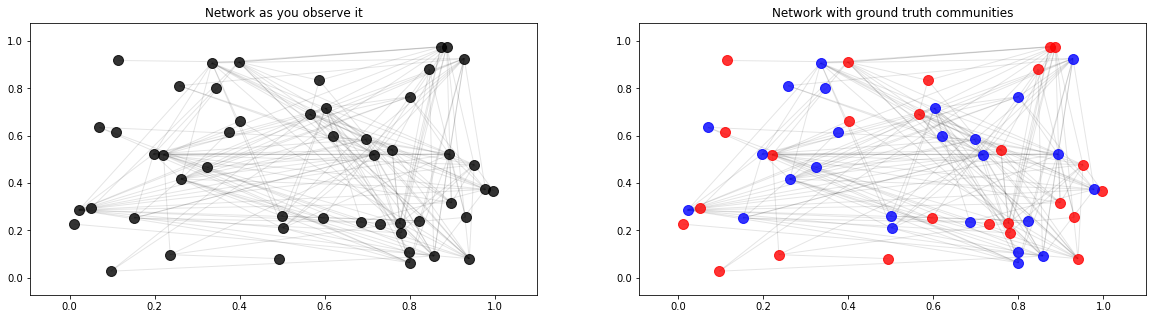

In [16]:
graph = DCSBM(n = int(n/6), lambda_n = lambda_n/2, r = r, w = w)
plot_network(graph)

#### DCSBM Representation, n = 300

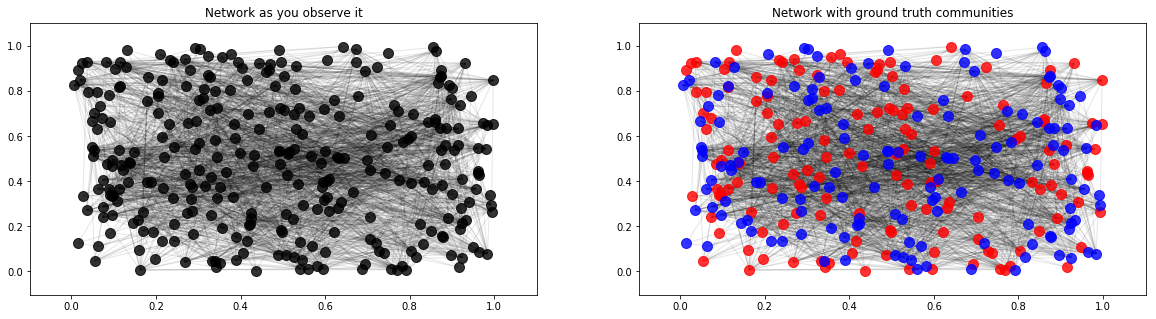

In [17]:
graph = DCSBM(n = n, lambda_n = lambda_n, r = r, w = w)
plot_network(graph)

### Low-Rank Approximation

**A. Regularized Spectral Clustering (SCR)**:

1. Compute Eigenvectors of Regularized Laplacian
2. Compute KMeans with 2 firest eigenvectors $u_1$, $u_2$ as input.
3. Get Labels from trained Kmeans

Normalized Mutual Score on one experiment using SCR :  0.7734130930333452


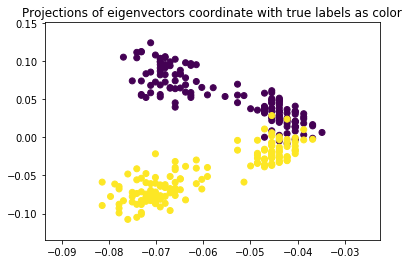

In [18]:
V, Z = eig_laplacian_regularized(graph.adjency_matrix, k=2, tau= tau)
Kmeans = KMeans(n_clusters=2, random_state=0, init ='random', n_init = 40).fit(Z)

print('Normalized Mutual Score on one experiment using SCR : ', \
      normalized_mutual_info_score(labels_true = graph.labels, labels_pred = Kmeans.labels_, 
                                         average_method='arithmetic'))

plt.title('Projections of eigenvectors coordinate with true labels as color')
plt.scatter(Z[:,0], Z[:,1], c = graph.labels)
plt.show()

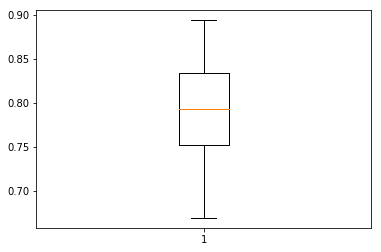

In [19]:
NMI_values = []
for i in tqdm.tqdm_notebook(range(100)):
    graph = DCSBM(n = n, lambda_n = lambda_n, r = r, w = w)
    #if graph.misfits ==0  :
    V, Z = eig_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
    Kmeans = KMeans(n_clusters=2, random_state=i, init ='random', n_init =40).fit(Z)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = Kmeans.labels_, average_method='arithmetic' )
    NMI_values.append(NMI)
    #else : 
        #print('Misfits in Network')

plt.boxplot(NMI_values)
plt.show()

- Remark : without regularization, leadings eigenvectors of the Laplacian of A tends to localize around the small connected components. 

**B. Approximate Extreme Points (AEP)** : 

1. use $(D^{1/2}u_1, D^{1/2}u_2)$  to compute the $U_A$ matrix/
2. 

In [20]:
def U_from_laplacian_regularized(A, k=2, tau = 0.001):
    A_t = np.add(A, tau)
    n = np.shape(A_t)[0]
    D = np.diag(1 / np.sqrt(np.ravel(A_t.sum(axis=0))))
    L = np.identity(n) - D.dot(A_t).dot(D)
    V,Z = eigsh(L, k, which='SM')
    return np.dot(D,Z)
U_A = U_from_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
#indices = np.argsort(np.abs(U_A[:,1]))[::-1] #Highest to smallest

In [21]:
c_pred = np.dot(np.dot(U_A[:,0].T, np.ones(n)), U_A[:,1]) -  np.dot(np.dot(U_A[:,1].T, np.ones(n)), U_A[:,0])
c_pred = np.sign(c_pred)
NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = c_pred, average_method='arithmetic' )
print(NMI)

0.8433329487279597


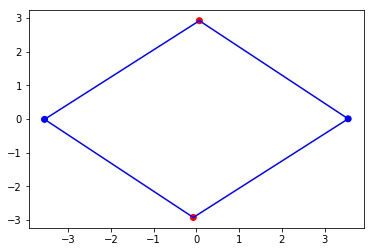

In [22]:
# for i in tqdm.tqdm_notebook(range(n*10)):
#     vec = [(-1)**(np.random.binomial(1,0.5)+1) for j in range(n)]
#     plt.scatter(np.dot(U_A.T,vec)[0], np.dot(U_A.T,vec)[1])

constant_pos = np.dot(U_A.T,[1]*300)
constant_neg = np.dot(U_A.T,[-1]*300)

pred_pos = np.dot(U_A.T,c_pred)
pred_neg = np.dot(U_A.T,np.multiply(c_pred,-1))

points = np.array([constant_pos, constant_neg, pred_pos, pred_neg])
#plt.scatter(constant_pos[0], constant_pos[1], color = 'b')
#plt.scatter(constant_neg[0], constant_neg[1], color='b')
#plt.scatter(np.dot(U_A.T,graph.labels)[0], np.dot(U_A.T, graph.labels)[1], color='b')
#plt.scatter(np.dot(U_A.T,np.multiply(graph.labels,-1))[0], np.dot(U_A.T, np.multiply(graph.labels, -1))[1], color = 'b')
#plt.scatter(np.dot(U_A.T,c_pred)[0], np.dot(U_A.T, c_pred)[1], color='r')
#plt.scatter(np.dot(U_A.T,np.multiply(c_pred,-1))[0], np.dot(U_A.T, np.multiply(c_pred, -1))[1], color = 'r')
#plt.plot(x,y,zorder=1)
plt.scatter(points[:,0], points[:,1], color= ['b','b','r','r'])
plt.plot(points[[1,2],0],points[[1,2],1], color='b')
plt.plot(points[[1,3],0],points[[1,3],1], color='b')
plt.plot(points[[0,2],0],points[[0,2],1], color='b')
plt.plot(points[[0,3],0],points[[0,3],1], color='b')

plt.show()

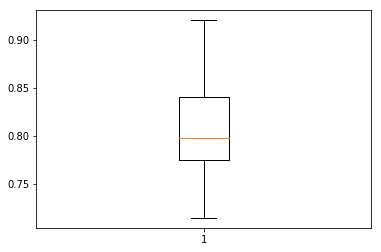

In [23]:
NMI_values = []
for i in tqdm.tqdm_notebook(range(100)):
    graph = DCSBM(n = n, lambda_n = lambda_n, r = r, w = w)
    #if graph.misfits ==0  :
    U_A = U_from_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
    c_pred = np.dot(np.dot(U_A[:,0].T, np.ones(n)), U_A[:,1]) -  np.dot(np.dot(U_A[:,1].T, np.ones(n)), U_A[:,0])
    c_pred = np.sign(c_pred)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = c_pred, average_method='arithmetic' )
    NMI_values.append(NMI)
    #else : 
        #print('Misfits in Network')

plt.boxplot(NMI_values)
plt.show()

**C. Extreme Points (EM)** : 

1. use $(D^{1/2}u_1, D^{1/2}u_2)$  to compute the $U_A$ matrix/
2. Sort angles between columns vector of $U_A$ and the $x$-axis.

In [582]:
U_A = U_from_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
indices = np.argsort(np.abs(U_A[:,1]))[::-1] #Highest to smallest
em_pred = np.ones(n)
len(indices)
vec = np.zeros(n)

for i in range(300):
    for j in range(300):
        vec = np.zeros(n)
        vec[indices[j]] = 2*(-1)**(max(0,em_pred[indices[j]]))
        em_pred_ = em_pred + vec
        if np.abs(np.dot(U_A.T, em_pred)[1]) < np.abs(np.dot(U_A.T, em_pred_)[1]):
            #print(i,j)
            em_pred = em_pred + vec
            break
print(em_pred)
NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = em_pred, average_method='arithmetic' )

[-1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

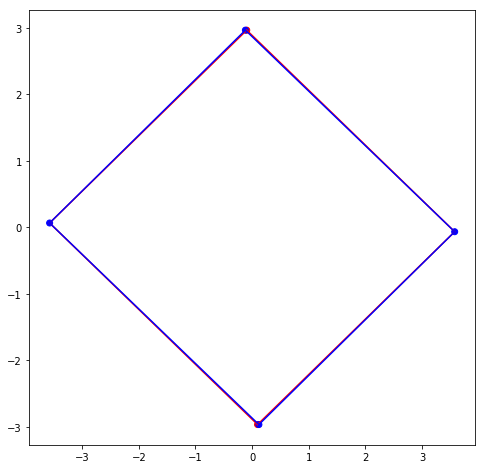

In [587]:
constant_pos = np.dot(U_A.T,[1]*300)
constant_neg = np.dot(U_A.T,[-1]*300)

pred_pos = np.dot(U_A.T,c_pred)
pred_neg = np.dot(U_A.T,np.multiply(c_pred,-1))

em_pred_pos = np.dot(U_A.T,em_pred)
em_pred_neg = np.dot(U_A.T,np.multiply(em_pred,-1))

points = np.array([constant_pos, constant_neg, pred_pos, pred_neg, em_pred_pos, em_pred_neg])

plt.figure(figsize=(8,8))
plt.scatter(points[:,0], points[:,1], color= ['b','b','r','r','b','b'])
plt.plot(points[[1,2],0],points[[1,2],1], color='r')
plt.plot(points[[1,3],0],points[[1,3],1], color='r')
plt.plot(points[[0,2],0],points[[0,2],1], color='r')
plt.plot(points[[0,3],0],points[[0,3],1], color='r')
plt.plot(points[[1,4],0],points[[1,4],1], color='b')
plt.plot(points[[1,5],0],points[[1,5],1], color='b')
plt.plot(points[[0,4],0],points[[0,4],1], color='b')
plt.plot(points[[0,5],0],points[[0,5],1], color='b')

plt.show()

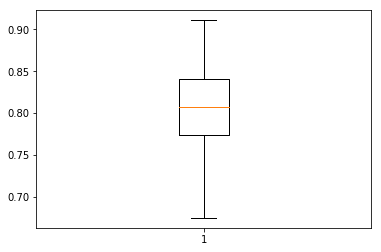

In [588]:
NMI_values = []
for i in tqdm.tqdm_notebook(range(100)):
    graph = DCSBM(n = n, lambda_n = lambda_n, r = r, w = w)
    U_A = U_from_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
    indices = np.argsort(np.abs(U_A[:,1]))[::-1] #Highest to smallest
    em_pred = np.ones(n)
    vec = np.zeros(n)
    for i in range(300):
        for j in range(300):
            vec = np.zeros(n)
            vec[indices[j]] = 2*(-1)**(max(0,em_pred[indices[j]]))
            em_pred_ = em_pred + vec
            if np.abs(np.dot(U_A.T, em_pred)[1]) < np.abs(np.dot(U_A.T, em_pred_)[1]):
                #print(i,j)
                em_pred = em_pred + vec
                break
    #print(em_pred)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = em_pred, average_method='arithmetic' )
    NMI_values.append(NMI)
    #else : 
        #print('Misfits in Network')

plt.boxplot(NMI_values)
plt.show()

**D. Conditional Pseudo-Likelihood (CPL)**:  
https://arxiv.org/pdf/1207.2340.pdf

- node degree $d_i = \sum_k b_{ik}$
- $b_{ik} = \sum_j A_{ij}I(e_j=k)$ block sums along the columns
- initial labeling vector $e = (e_1, ..., e_n)$ that we'll take equal to the output of SCR.
- $\theta_{kl} = \frac{\lambda_{kl}}{\lambda_k}$
- $R_{ka}=\frac{1}{n} \sum_{i=1}^{n} I(e_i=k, c_i=a)$
- $\lambda_{lk} = n R_{k\cdot}P_{\cdot l}$

Conditional pseudo log likelihood : 

$$ l_{CPL}(\pi, \theta,(b_i)) = \sum_{i=1}^{n} \log\left( \sum_{l=1}^{K} \pi_l \prod_{k=1}^{K} \theta_{lk}^{b_{ik}} \right)$$

$$ l_{CPL}(\pi, \theta,(b_i)) = \sum_{i=1}^{n} \log\left( \sum_{l=1}^{2} \pi_l \prod_{k=1}^{2} \theta_{lk}^{b_{ik}} \right)$$
$$ l_{CPL}(\pi, \theta,(b_i)) = \sum_{i=1}^{n} \log\left(\pi_1 \theta_{11}^{b_{i1}}\theta_{12}^{b_{i2}} + \pi_2 \theta_{21}^{b_{i1}}\theta_{22}^{b_{i2}} \right)$$

Algo : 
- compute $(b_{ik})$.
- using current estimate of \pi and \theta : 
$$\pi_{il} = \mathbb{P}_{CPL}(c_i=l|b_i)=\frac{\hat{\pi_l}\prod_{m=1}^{K}\hat{\theta}_{lm}^{b_{im}}} {\sum_{k=1}^{K} \hat{\pi_k}\prod_{m=1}^{K}\hat{\theta}_{km}^{b_{im}}}$$
- given probabilities : update parameters values as follow : 
$$\hat{\pi}_l = \frac{1}{n} \sum_{i=1}^{n} \hat{\pi}_{il}$$

$$\hat{\theta}_{ik} = \frac{\sum_i \hat{\pi}_{il}b_{ik}}{\sum_i \hat{\pi}_{il}d_i}$$
- Return to step 2 unless the parameters estimates have converged
- Update labels by $e_i = argmax_l \hat{\pi_{il}}$ and return to step 1.
- Update $\hat{P}$ as follow : 
$$\hat{P}_{lk}=\frac{\sum_{ij}A_{ij}\hat{\pi}_{il} \hat{\pi}_{jk}}{n_{lk}(e)}$$

In [692]:
graph = DCSBM(n = n, lambda_n = lambda_n, r = r, w = w)
#if graph.misfits ==0  :
V, Z = eig_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
Kmeans = KMeans(n_clusters=2, random_state=i, init ='random', n_init =40).fit(Z)
NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = Kmeans.labels_, average_method='arithmetic' )
NMI

0.8274741231992806

In [693]:
initial_e = 2*Kmeans.labels_-1
e = initial_e
A =  graph.adjency_matrix
pi = np.array([(n-np.maximum(initial_e,0).sum())/n, np.maximum(initial_e,0).sum()/n])
R = np.diag(pi)
P = np.zeros((2,2))
for l in range(2):
    for k in range(2):
        e1 = (initial_e == (-1)**(-l+1)).astype(int)
        e2 = (initial_e == (-1)**(-k+1)).astype(int)
        P[l,k] = np.dot(np.dot(e1.T, A), e2)/(pi[0]*pi[1]*n**2)
        print(np.dot(np.dot(e1.T, A), e2))
lambda_ = n*np.dot(R, P)
lambda_
print("pi", pi)

theta = np.zeros((2,2))
for l in range(2):
    for k in range(2):
        theta[l,k] = lambda_[l,k]/lambda_[l,:].sum()
print(lambda_, theta)
        
def prod_exp(vector, exp):
    prod = 1
    for i in range(len(vector)):
        #print(prod, vector[i], exp[i], (vector[i]**exp[i]))
        prod = prod*(vector[i]**exp[i])
    return prod

pi_copy = np.zeros((n,2))

b= np.zeros((n,2))

for iterations in range(20):

    for it in range(1):
        #Step 1
        for i in range(n):
            for k in range(2):
                e_j =  (initial_e == (-1)**(-k+1)).astype(int)
                b[:,k] = np.dot(A, e_j)
        for i in range(n):
            for l in range(2):
                pi_il = pi[l] * prod_exp(theta[l,:], b[i,:])
                pi_il = pi_il/ (pi[0] * prod_exp(theta[0,:], b[i,:])+pi[1] * prod_exp(theta[1,:], b[i,:]))
                pi_copy[i,l] = pi_il

        for l in range(2):
            pi[l] = np.mean(pi_copy[:,l])
            for k in range(2):
                theta[l,k] =  np.dot(pi_copy[:,l].T,b[:,k]) / np.dot(pi_copy[:,l].T, np.sum(b, axis=1))

    #5. Update Labels e
    e = np.argmax(pi_copy, axis=1)
    e = e*2 -1
#print(em_pred)
#print(e)
#Update P
em_pred==e

2008.0
350.0
350.0
2076.0
pi [0.51333333 0.48666667]
[[13.75342466  2.39726027]
 [ 2.27272727 13.48051948]] [[0.85156913 0.14843087]
 [0.1442704  0.8557296 ]]


array([False, False, False, False, False,  True, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False,  True,

In [694]:
NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = e, average_method='arithmetic' )
NMI

0.8274741231992806

In [662]:
pi_il = pi[l] * prod_exp(theta[l,:], b[i,:])
print(pi_il,theta[l,:], b[i,:], prod_exp(theta[l,:], b[i,:]))
print((pi[0] * prod_exp(theta[0,:], b[i,:])+pi[1] * prod_exp(theta[1,:], b[i,:])))
pi_il = pi_il/ (pi[0] * prod_exp(theta[0,:], b[i,:])+pi[1] * prod_exp(theta[1,:], b[i,:]))
print(pi_il)
pi_copy[i,l] = pi_il

4.0719830459150795e-05 [0.84736842 0.15263158] [23.  3.] 7.881257508222734e-05
4.071983045915107e-05
0.9999999999999932


In [640]:
0.84736842**23 + 0.15263158**3

0.025720489539928827

In [660]:
prod = 0.
vector = [0.84736842, 0.15263158]
exp = [23., 3.] 
for i in range(len(vector)):
    print(prod)
    prod = prod*(vector[i]**exp[i])
prod

0.0
0.0


0.0

In [ ]:
## Durty Code : 



# Laplacian = scipy.sparse.csgraph.laplacian(graph.adjency_matrix)
# values, vectors = scipy.sparse.linalg.eigsh(Laplacian, k=2)
# #values, vectors = np.linalg.eig(Laplacian)
# # ind1 = np.argmax(np.abs(values))
# # u1 = vectors[ind1,:]
# # #print(u1.shape)
# # temp = np.abs(values).copy()
# # temp[ind1] = -np.inf
# # ind2 = np.argmax(temp)
# # u2 = vectors[ind2,:]
# # print(ind1,ind2)
# #print(u1, u2)
# from sklearn.cluster import KMeans
# #X = np.concatenate([u1[:,np.newaxis],u2[:,np.newaxis]], axis=1)
# Kmeans = KMeans(n_clusters=2, random_state=0).fit(vectors)
# plt.scatter(vectors[:,0],vectors[:,1], c = graph.labels)
# plt.show()

# def spectral_clust(A, k=2):
#     n = np.shape(A)[0]
#     V, Z = eig_laplacian(A, k)
#     print(Z.shape)
    
#     rows_norm = np.linalg.norm(Z, axis=1, ord=2)
#     Y = (Z.T / rows_norm).T
#     centroids, distortion = kmeans(Y, k)
    
#     y_hat = np.zeros(n, dtype=int)
#     for i in range(n):
#         dists = np.array([np.linalg.norm(Y[i] - centroids[c]) for c in range(k)])
#         y_hat[i] = np.argmin(dists)
#     return y_hat

# np.add(np.zeros((3,3)), 0.1)

# graph.adjency_matrix

# print('Group1', [i for i,label in enumerate(Kmeans.labels_) if label==0])
# print('\nGroup2', [i for i,label in enumerate(Kmeans.labels_) if label==1])

# print('Group1', [i for i,label in enumerate(pred_labels) if label==0])
# print('\nGroup2', [i for i,label in enumerate(pred_labels) if label==1])
# print(graph.labels)
# (graph.labels == pred_labels).sum()/n

# print('Group1', [i for i,label in enumerate(graph.labels) if label==0])
# print('\nGroup2', [i for i,label in enumerate(graph.labels) if label==1])

# from sklearn.metrics.cluster import normalized_mutual_info_score
# #normalized_mutual_info_score(labels_true = graph.labels, labels_pred = [1 if pred==0 else 0 for pred in pred_labels])
# normalized_mutual_info_score(labels_true = graph.labels, labels_pred = pred_labels)

In [41]:
initial_e = 2*Kmeans.labels_-1
def CPL(graph, initial_e):
    e = initial_e
    A =  graph.adjency_matrix
    pi = np.array([(n-np.maximum(initial_e,0).sum())/n, np.maximum(initial_e,0).sum()/n])
    R = np.diag(pi)
    P = np.zeros((2,2))
    for l in range(2):
        for k in range(2):
            e1 = (initial_e == (-1)**(-l+1)).astype(int)
            e2 = (initial_e == (-1)**(-k+1)).astype(int)
            P[l,k] = np.dot(np.dot(e1.T, A), e2)/(pi[0]*pi[1]*n**2)
            #print(np.dot(np.dot(e1.T, A), e2))
    lambda_ = n*np.dot(R, P)
    lambda_
    #print("pi", pi)

    theta = np.zeros((2,2))
    for l in range(2):
        for k in range(2):
            theta[l,k] = lambda_[l,k]/lambda_[l,:].sum()
    #print(lambda_, theta)

    def prod_exp(vector, exp):
        prod = 1
        for i in range(len(vector)):
            #print(prod, vector[i], exp[i], (vector[i]**exp[i]))
            prod = prod*(vector[i]**exp[i])
        return prod

    pi_copy = np.zeros((n,2))

    b= np.zeros((n,2))

    for iterations in range(20):
        
        #Step 1
        for i in range(n):
            for k in range(2):
                e_j =  (e == (-1)**(-k+1)).astype(int)
                b[:,k] = np.dot(A, e_j)
                
        # Until Convergence
        for it in range(10):

            #Step 2 : estimate probabilities for node labels, pi_table
            for i in range(n):
                for l in range(2):
                    pi_il = pi[l] * prod_exp(theta[l,:], b[i,:])
                    pi_il = pi_il/ (pi[0] * prod_exp(theta[0,:], b[i,:])+pi[1] * prod_exp(theta[1,:], b[i,:]))
                    pi_copy[i,l] = pi_il

            #Step 3 : Update parameters values pi and theta
            for l in range(2):
                pi[l] = np.mean(pi_copy[:,l])
                for k in range(2):
                    theta[l,k] =  np.dot(pi_copy[:,l].T,b[:,k]) / np.dot(pi_copy[:,l].T, np.sum(b, axis=1))
            # Step 4 ; wait fo the parameters estimates to converge
            
        #Step 5. Update Labels e and return to step 1
        e = np.argmax(pi_copy, axis=1)
        e = e*2 -1

    return e

In [42]:
SCR_values = []
AEP_values = []
EP_values = []
CPL_values = []

for i in tqdm.tqdm_notebook(range(50)):
    
    graph = DCSBM(n = n, lambda_n = lambda_n, r = r, w = w)

    #SCR
    V, Z = eig_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
    Kmeans = KMeans(n_clusters=2, random_state=i, init ='random', n_init =40).fit(Z)
    SCR_pred = Kmeans.labels_
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = SCR_pred, average_method='arithmetic' )
    SCR_values.append(NMI)

    #AEP
    U_A = U_from_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
    AEP_pred = np.dot(np.dot(U_A[:,0].T, np.ones(n)), U_A[:,1]) -  np.dot(np.dot(U_A[:,1].T, np.ones(n)), U_A[:,0])
    AEP_pred = np.sign(AEP_pred)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = AEP_pred, average_method='arithmetic' )
    AEP_values.append(NMI)

    indices = np.argsort(np.abs(U_A[:,1]))[::-1] #Highest to smallest
    em_pred = np.ones(n)
    vec = np.zeros(n)
    for i in range(300):
        for j in range(300):
            vec = np.zeros(n)
            vec[indices[j]] = 2*(-1)**(max(0,em_pred[indices[j]]))
            em_pred_ = em_pred + vec
            if np.abs(np.dot(U_A.T, em_pred)[1]) < np.abs(np.dot(U_A.T, em_pred_)[1]):
                #print(i,j)
                em_pred = em_pred + vec
                break
    #print(em_pred)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = em_pred, average_method='arithmetic' )
    EP_values.append(NMI)
    
    initial_e = 2*SCR_pred-1
    CPL_pred = CPL(graph, initial_e)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = CPL_pred, average_method='arithmetic' )
    CPL_values.append(NMI)


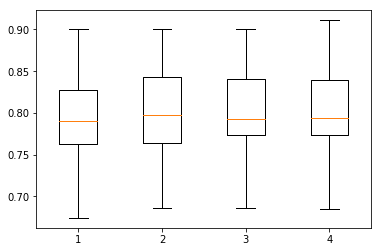

In [40]:
plt.boxplot([SCR_values,AEP_values,EP_values,CPL_values])
plt.show()

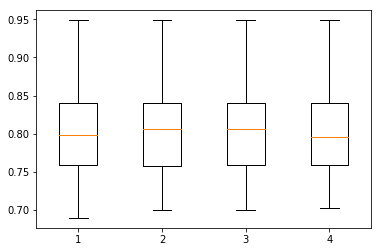

In [43]:
plt.boxplot([SCR_values,AEP_values,EP_values,CPL_values])
plt.show()

In [82]:
class SBM :
    
    ''' Stochastic Block Model'''
    
    def __init__(self,n, lambda_n, r, w):
        self.n = n
        self.probas =np.array([[1,r],[r,w]])
        
        gamma_ = 0
        self.theta = [np.random.binomial(1,gamma_) for draw in range(self.n)]
        self.theta = [0.2 if draw==1. else 1. for draw in self.theta ]  
        P = lambda_n* self.probas / ((self.n-1)*(np.dot(np.dot((1/self.n)*np.array([self.n/2,self.n/2]), self.probas),(1/self.n)*np.array([self.n/2,self.n/2]))* np.mean(self.theta)**2))
        self.probas = P
        
        #self.labels = [np.argmax(np.random.multinomial(1, [1/2, 1/2])) for i in range(n)]
        #self.labels = [0]*int(self.n/2) + [1]*(self.n-int(self.n/2))
        self.labels = [np.random.binomial(1,0.5) for i in range(n)]

        self.adjency_matrix = np.identity(n)
        self.edges = []
        self.get_adjency_edges()
        self.misfits = self.count_misfits()
        
    def get_adjency_edges(self):
        for i in range(self.n):
            for j in range(i):
                #draw A_ij = Bernouilly(theta_i * thetaj * Pc_i, c_j)
                ci, cj = self.labels[i], self.labels[j]
                edge = np.random.binomial(1,self.theta[i]*self.theta[j]*self.probas[ci, cj])
                if edge == 1 :
                    self.edges.append((i,j))
                    self.adjency_matrix[i,j] = edge
                    self.adjency_matrix[j,i] = edge
                    
    def count_misfits(self):      
        count = 0
        for i in range(self.n):
            if self.adjency_matrix[i,:].sum() ==1  :
                count+=1
        return count

In [80]:
def UPL(graph, initial_e):
    
    #Initialization of e, pu, R, P, lambda
    e = initial_e
    A =  graph.adjency_matrix
    pi = np.array([(n-np.maximum(initial_e,0).sum())/n, np.maximum(initial_e,0).sum()/n])
    R = np.diag(pi)
    P = np.zeros((2,2))
    for l in range(2):
        for k in range(2):
            e1 = (initial_e == (-1)**(-l+1)).astype(int)
            e2 = (initial_e == (-1)**(-k+1)).astype(int)
            P[l,k] = np.dot(np.dot(e1.T, A), e2)/(pi[0]*pi[1]*n**2)
            #print(np.dot(np.dot(e1.T, A), e2))
    lambda_ = n*np.dot(R, P)


    def prod_exp(lambda_l, bi):
        prod = 1
        for m in range(len(lambda_l)):
            #print(prod, vector[i], exp[i], (vector[i]**exp[i]))
            prod = prod*np.exp(bi[m]*np.log(lambda_l[m]) - lambda_l[m] )
        return prod

    pi_table = np.zeros((n,2))

    b= np.zeros((n,2))

    for iterations in range(20):
        
        #Step 1 : Compute block sum b_il
        for i in range(n):
            for k in range(2):
                e_j =  (e == (-1)**(-k+1)).astype(int)
                b[:,k] = np.dot(A, e_j)

        # Until convergence
        for it in range(10):
                    
            #Step 2 : estimate probabilities for nod labels, pi_table
            for i in range(n):
                for l in range(2):
                    pi_il = pi[l] * prod_exp(lambda_[l,:], b[i,:])
                    pi_il = pi_il/ (pi[0] * prod_exp(lambda_[0,:], b[i,:]) \
                                    + pi[1] * prod_exp(lambda_[1,:], b[i,:]))
                    pi_table[i,l] = pi_il

            #Step 3 : Update parameters values pi and lambda_
            for l in range(2):
                pi[l] = np.mean(pi_table[:,l])
                for k in range(2):
                    lambda_[l,k] =  np.dot(pi_table[:,l].T,b[:,k]) / pi_table[:,l].sum()
            # Step 4 : wait fo the parameters estimates to converge
        
        #Step 5. Update Labels e and return to step 1
        e = np.argmax(pi_table, axis=1)
        e = e*2 -1

    return e

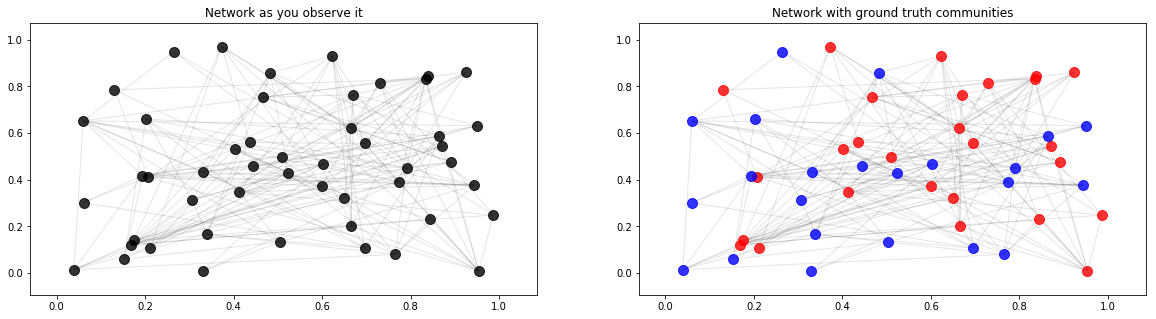

In [83]:
graph = SBM(n = int(n/6), lambda_n = lambda_n/2, r = r, w = w)
plot_network(graph)

In [84]:
SCR_values = []
AEP_values = []
EP_values = []
UPL_values = []
for i in tqdm.tqdm_notebook(range(50)):
    
    graph = SBM(n = n, lambda_n = lambda_n, r = r, w = w)

    #SCR
    V, Z = eig_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
    Kmeans = KMeans(n_clusters=2, random_state=i, init ='random', n_init =40).fit(Z)
    SCR_pred = Kmeans.labels_
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = SCR_pred, average_method='arithmetic' )
    SCR_values.append(NMI)

    #AEP
    U_A = U_from_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
    AEP_pred = np.dot(np.dot(U_A[:,0].T, np.ones(n)), U_A[:,1]) -  np.dot(np.dot(U_A[:,1].T, np.ones(n)), U_A[:,0])
    AEP_pred = np.sign(AEP_pred)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = AEP_pred, average_method='arithmetic' )
    AEP_values.append(NMI)

    indices = np.argsort(np.abs(U_A[:,1]))[::-1] #Highest to smallest
    em_pred = np.ones(n)
    vec = np.zeros(n)
    for i in range(300):
        for j in range(300):
            vec = np.zeros(n)
            vec[indices[j]] = 2*(-1)**(max(0,em_pred[indices[j]]))
            em_pred_ = em_pred + vec
            if np.abs(np.dot(U_A.T, em_pred)[1]) < np.abs(np.dot(U_A.T, em_pred_)[1]):
                #print(i,j)
                em_pred = em_pred + vec
                break
    #print(em_pred)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = em_pred, average_method='arithmetic' )
    EP_values.append(NMI)
    
    initial_e = 2*SCR_pred-1
    UPL_pred = UPL(graph, initial_e)
    NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = UPL_pred, average_method='arithmetic' )
    UPL_values.append(NMI)

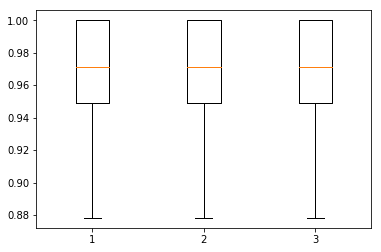

In [48]:
plt.boxplot([SCR_values,AEP_values,EP_values, UPL_values])
plt.show()

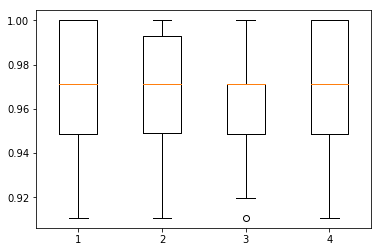

In [85]:
plt.boxplot([SCR_values,AEP_values,EP_values, UPL_values])
plt.show()

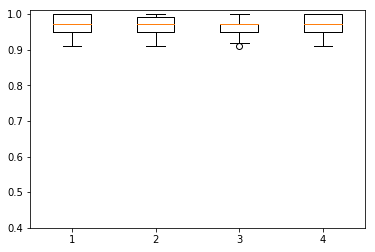

In [87]:
plt.ylim((0.4,1.01))
plt.boxplot([SCR_values,AEP_values,EP_values, UPL_values])
plt.show()

In [89]:
SCR_plt = []
AEP_plt = []
EP_plt = []
UPL_plt = []

for r_test in  tqdm.tqdm_notebook([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]):
    
    SCR_r = []
    AEP_r = []
    EP_r = []
    UPL_r = []

    for i in range(10):

        graph = SBM(n = n, lambda_n = lambda_n, r = r_test, w = w)

        #SCR
        V, Z = eig_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
        Kmeans = KMeans(n_clusters=2, random_state=i, init ='random', n_init =40).fit(Z)
        SCR_pred = Kmeans.labels_
        NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = SCR_pred, average_method='arithmetic' )
        SCR_r.append(NMI)

        #AEP
        U_A = U_from_laplacian_regularized(graph.adjency_matrix, 2, tau = tau)
        AEP_pred = np.dot(np.dot(U_A[:,0].T, np.ones(n)), U_A[:,1]) -  np.dot(np.dot(U_A[:,1].T, np.ones(n)), U_A[:,0])
        AEP_pred = np.sign(AEP_pred)
        NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = AEP_pred, average_method='arithmetic' )
        AEP_r.append(NMI)

        indices = np.argsort(np.abs(U_A[:,1]))[::-1] #Highest to smallest
        em_pred = np.ones(n)
        vec = np.zeros(n)
        for i in range(300):
            for j in range(300):
                vec = np.zeros(n)
                vec[indices[j]] = 2*(-1)**(max(0,em_pred[indices[j]]))
                em_pred_ = em_pred + vec
                if np.abs(np.dot(U_A.T, em_pred)[1]) < np.abs(np.dot(U_A.T, em_pred_)[1]):
                    #print(i,j)
                    em_pred = em_pred + vec
                    break
        #print(em_pred)
        NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = em_pred, average_method='arithmetic' )
        EP_r.append(NMI)

        initial_e = 2*SCR_pred-1
        UPL_pred = UPL(graph, initial_e)
        NMI = normalized_mutual_info_score(labels_true = graph.labels, labels_pred = UPL_pred, average_method='arithmetic' )
        UPL_r.append(NMI)
    SCR_plt.append(np.mean(SCR_r))
    AEP_plt.append(np.mean(AEP_r))
    EP_plt.append(np.mean(EP_r))
    UPL_plt.append(np.mean(UPL_r))

Exception in thread Thread-25:
Traceback (most recent call last):
  File "C:\Users\damie\AppData\Local\Continuum\anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\damie\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\damie\AppData\Local\Continuum\anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

C:\Users\damie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
C:\Users\damie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\damie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
C:\Users\damie\AppData\Local\Continuum\ana

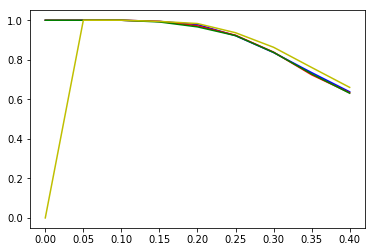

In [99]:
xaxis = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

plt.plot( xaxis, SCR_plt, color = 'b')
plt.plot(xaxis, AEP_plt, color = 'r')
plt.plot(xaxis, EP_plt, color = 'g')
plt.plot(xaxis, UPL_plt, color = 'y')
plt.show()

## 4. Real-word network Data : PolBlogs

In [303]:
import networkx as nx
import zipfile

s = r'C:\Users\damie\Desktop\M2 - ENSAE\6. Compressed Sensing\Project\polblogs.zip'
zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read('polblogs.txt').decode()  # read info file
gml = zf.read('polblogs.gml').decode()  # read gml data

gml = gml.split('\n')[1:]
gml.insert(2, "  multigraph 1")

#gml.pop(1)
#gml.insert(1, "  undirected 1")

G = nx.parse_gml(gml) 
G=G.to_undirected()

In [304]:
print(txt)

Political blogosphere Feb. 2005
Data compiled by Lada Adamic and Natalie Glance

Node "value" attributes indicate political leaning according to:

  0 (left or liberal)
  1 (right or conservative)

Data on political leaning comes from blog directories as indicated.  Some
blogs were labeled manually, based on incoming and outgoing links and posts
around the time of the 2004 presidential election.  Directory-derived
labels are prone to error; manual labels even more so.

Links between blogs were automatically extracted from a crawl of the front
page of the blog.

These data should be cited as Lada A. Adamic and Natalie Glance, "The
political blogosphere and the 2004 US Election", in Proceedings of the
WWW-2005 Workshop on the Weblogging Ecosystem (2005).



In [305]:
s=0
d = nx.degree(G)
for node in G.nodes():
    if d[node] ==0: 
        s+=1
print(len(G.nodes())-s)
len([node for node in G.nodes() if  d[node] > 0 ])

Gc = max(nx.connected_component_subgraphs(G), key=len)
print(len(Gc.nodes()))

1224
1222


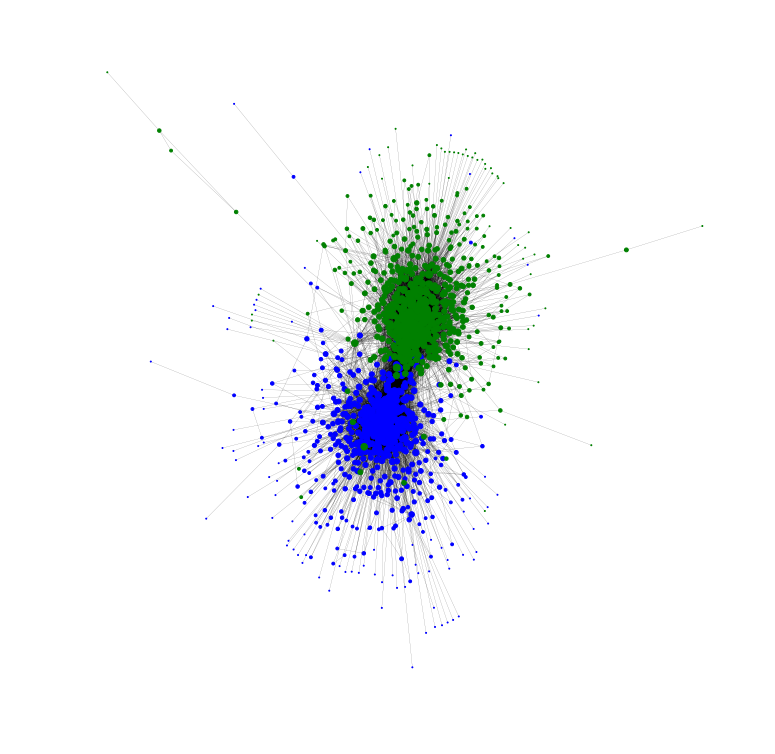

In [306]:
plt.figure(figsize=(10,10))
#graphs = list(nx.connected_component_subgraphs(G))
Gc = max(nx.connected_component_subgraphs(G), key=len)
len(Gc.nodes())
d = nx.degree(Gc)

options = {
    'line_color': 'black',
    'linewidths': 1,
    'alpha':1 ,
    'width':0.1,
}
color_map = []
for node in Gc.nodes():
    if Gc.nodes[node]['value']==0:
        color_map.append('blue')
    else: color_map.append('green')      
        

nx.draw(Gc,  nx.spring_layout(Gc) ,node_color = color_map,\
       #linewidths = [(0.1+max(0,np.log(d[node])))*1 for node in Gc.nodes()],
       node_size=[(0.1+max(0,np.log(d[node])))*10 for node in Gc.nodes()], **options) 

plt.show()

In [307]:
adjency_matrix = nx.adjacency_matrix(Gc).todense() + np.identity(1222)
true_labels = [int(Gc.nodes[node]['value']) for node in Gc.nodes()]
 #SCR
V, Z = eig_laplacian_regularized(adjency_matrix, 2, tau = tau)
Kmeans = KMeans(n_clusters=2, random_state=i, init ='random', n_init =40).fit(Z)
SCR_pred = Kmeans.labels_
NMI = normalized_mutual_info_score(labels_true = true_labels, labels_pred = SCR_pred, average_method='arithmetic' )
print('NMI SCR = ', NMI)
SCR_values.append(NMI)

#AEP
U_A = U_from_laplacian_regularized(adjency_matrix, 2, tau = tau)
AEP_pred = np.dot(np.dot(U_A[:,0].T, np.ones(1222)), U_A[:,1]) -  np.dot(np.dot(U_A[:,1].T, np.ones(1222)), U_A[:,0])
AEP_pred = np.sign(AEP_pred)
NMI = normalized_mutual_info_score(labels_true = true_labels, labels_pred = AEP_pred, average_method='arithmetic' )
AEP_values.append(NMI)
print('NMI AEP = ', NMI)

NMI SCR =  0.2392710601873821
NMI AEP =  0.6104816535206086


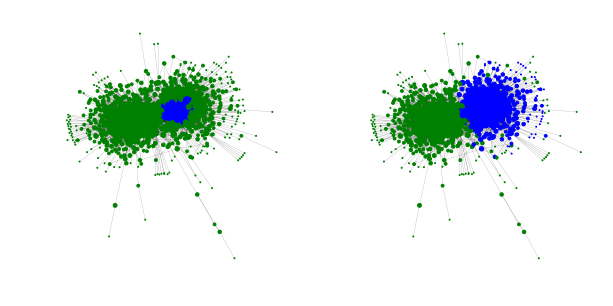

In [308]:
plt.figure(figsize=(10,5))

plt.subplot(121)
options = {
    'line_color': 'black',
    'linewidths': 1,
    'alpha':1 ,
    'width':0.1,
}
color_map = []
for node in range(len(Gc.nodes())):
    if SCR_pred[node]==0:
        color_map.append('blue')
    else: color_map.append('green')      

layout = nx.spring_layout(Gc)

nx.draw(Gc,  layout ,node_color = color_map,\
       node_size=[(0.1+max(0,np.log(d[node])))*10 for node in Gc.nodes()], **options) 

plt.subplot(122)
color_map = []
for node in range(len(Gc.nodes())):
    if AEP_pred[node]==-1:
        color_map.append('blue')
    else: color_map.append('green')      
        

nx.draw(Gc,  layout ,node_color = color_map,\
       node_size=[(0.1+max(0,np.log(d[node])))*10 for node in Gc.nodes()], **options) 

plt.show()